In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

from experiment_utils import *
from src import *


pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


# SAVE TO RESULTS FILE

In [2]:
FOLDER = "RQ5_DIFF_MODELS"

if not os.path.exists(FOLDER):
    os.makedirs(FOLDER)

In [3]:
def f(df, reader): # Keep only K and KP
    df['TEMP'] = df['other'].apply(reader._get_losses_used)
    df = df[(~df["bias mitigation"].str.contains('FYP VAE')) | df["TEMP"].str.contains('Sensitive KL loss') ]
    df = df[~(df["TEMP"].str.contains("Flipped"))]
    df = df[~(df["TEMP"].str.contains("Latent"))]
    return df.drop(columns=['TEMP'])

### APPENDIX: all meatrics for all models KP, K and baselines

In [4]:
for attr in [["sex"],["race"],["race", "sex"]]:            
    files = [os.path.join("results","RESULTS_"+'_'.join(attr)+".csv")]
    
    reader = ResultsReader(files)    
    
    df = reader.get_mean_metrics() #f(reader.get_mean_metrics(), reader)
    
    metric_order = ['f1score', 'MCC', '[SF] Statistical Parity Subgroup Fairness', '[DF] Differential Fairness']
    metric_order = ['f1score', '[DF] Differential Fairness']
    group_cols = ['data','sensitive attrs', 'bias mitigation', 'other']
    df = df.pivot_table(index=group_cols, columns='ML method', values=metric_order)
    
    mean_df = df.groupby(group_cols).mean().reset_index()
        
    mean_df = mean_df.reindex(columns=sorted(mean_df.columns, key=lambda x: (x[1], metric_order.index(x[0]) if x[0] in metric_order else len(metric_order))))
    #mean_df = mean_df.reindex(sorted(mean_df.columns, key=lambda x: (x[1], x[0])), axis=1) # group by ml

    mean_df.to_csv(os.path.join(FOLDER,"MEAN_"+'_'.join(attr)+'.csv'), index=False)
    
    """
    df = f(reader.get_filtered_df(), reader)
    mean_df = df.groupby(reader.filterable).std().reset_index()
    mean_df.to_csv(os.path.join(FOLDER,"STD_"+'_'.join(attr)+'.csv'), index=False)
    """


File 'results\RESULTS_sex.csv' successfully loaded as DataFrame.
File 'results\RESULTS_race.csv' successfully loaded as DataFrame.
File 'results\RESULTS_race_sex.csv' successfully loaded as DataFrame.


### NR OF incr of SF BY MODEL

In [5]:
"""
For all baselines and my relavant losses count of times SF/F1 has been equal or higher than the 
baseline model, separately for each of the 6 ml models used
"""

for attr in [["sex"],["race"],["race", "sex"]]:
    #default_files = [os.path.join("results","MAIN_defualt_"+'_'.join(attr)+".csv") , os.path.join("results","defualt_"+'_'.join(attr)+".csv")] # TODO: REMOVE
    #files = default_files + [os.path.join("results","RESULTS_"+'_'.join(attr)+".csv")]
    files = [os.path.join("results","RESULTS_"+'_'.join(attr)+".csv")]
    reader = ResultsReader(files)
    reader.change_other_to_losses()

    rel_df = reader.get_relative_metrics()

    metrics_to_use = ["DF"]
    metrics_to_display = [m for m in reader.metrics if metric_has_substring(m,metrics_to_use )]
    #metrics_to_display = ['[SF] Statistical Parity Subgroup Fairness']
    metrics_to_display = ['[DF] Differential Fairness']
    
    df = rel_df# f(rel_df, reader)
        
    if df.shape[0] > 0: # in case some dataset has no results for some metrics
        counts_total = df[(df["bias mitigation"].str.contains('No'))].groupby(["bias mitigation", "other"]).count()[metrics_to_display]
        result = df.groupby(["data","bias mitigation", "other", "ML method"])[metrics_to_display].apply(lambda x: (x >= 0).sum()).reset_index()
        results = pd.concat([result, counts_total])
        
        for i, metric in enumerate(metrics_to_display):
            pivot_df = results.pivot_table(index=["data","bias mitigation", "other"], columns='ML method', values=metric, aggfunc='sum', fill_value=0)            
            pivot_df.to_csv(os.path.join(FOLDER,metrics_to_use[i]+'_PER_MODEL_nr_incr_'+"_".join(attr)+'.csv'), index=True,  index_label=["data","bias mitigation", "other"])

File 'results\RESULTS_sex.csv' successfully loaded as DataFrame.
File 'results\RESULTS_race.csv' successfully loaded as DataFrame.
File 'results\RESULTS_race_sex.csv' successfully loaded as DataFrame.


# VIS

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

from experiment_utils import *
from src import *


In [7]:
size = 3

In [8]:
def f(df, reader, ml_method='nn'): # Keep only K and KP
    df = df[(df["ML method"].str.contains(ml_method))]
    df['TEMP'] = df['other'].apply(reader._get_losses_used)
    #df = df[(~df["bias mitigation"].str.contains('FYP VAE'))  | df["TEMP"].str.contains('Sensitive KL loss') ]
    df = df[~(df["TEMP"].str.contains("Pos")) | df["TEMP"].str.contains('Sensitive KL loss') ]
    df = df[~(df["TEMP"].str.contains("Recon")) | df["TEMP"].str.contains('Sensitive KL loss') ]
    df = df[~(df["TEMP"].str.contains("Flipped"))]
    df = df[~(df["TEMP"].str.contains("Latent"))]
    return df.drop(columns=['TEMP'])

In [9]:
files, datasets, titles = get_all_single_attr_files(True)

In [10]:
models = [
    ["NN","nn keras"],
    ["SV","SupportVectorClassifier"],
    ["LR","LogisticRegression"],
    ["NB","NaiveBayes"],
    ["DT","DecisionTreeRegressor"],
    ["RF","RandomForestClassifier"],
]

File 'results\RESULTS_with_no_vae_sex.csv' successfully loaded as DataFrame.
metrics to display: [SF] Statistical Parity Subgroup Fairness f1score  | all found  ['sex|[SF] Statistical Parity Subgroup Fairness for One Attribute', '[SF] Statistical Parity Subgroup Fairness'] ['f1score']
File 'results\RESULTS_with_no_vae_race.csv' successfully loaded as DataFrame.
metrics to display: [SF] Statistical Parity Subgroup Fairness f1score  | all found  ['race|[SF] Statistical Parity Subgroup Fairness for One Attribute', '[SF] Statistical Parity Subgroup Fairness'] ['f1score']
File 'results\RESULTS_with_no_vae_sex.csv' successfully loaded as DataFrame.
metrics to display: [SF] Statistical Parity Subgroup Fairness f1score  | all found  ['sex|[SF] Statistical Parity Subgroup Fairness for One Attribute', '[SF] Statistical Parity Subgroup Fairness'] ['f1score']
File 'results\RESULTS_with_no_vae_race.csv' successfully loaded as DataFrame.
metrics to display: [SF] Statistical Parity Subgroup Fairness 

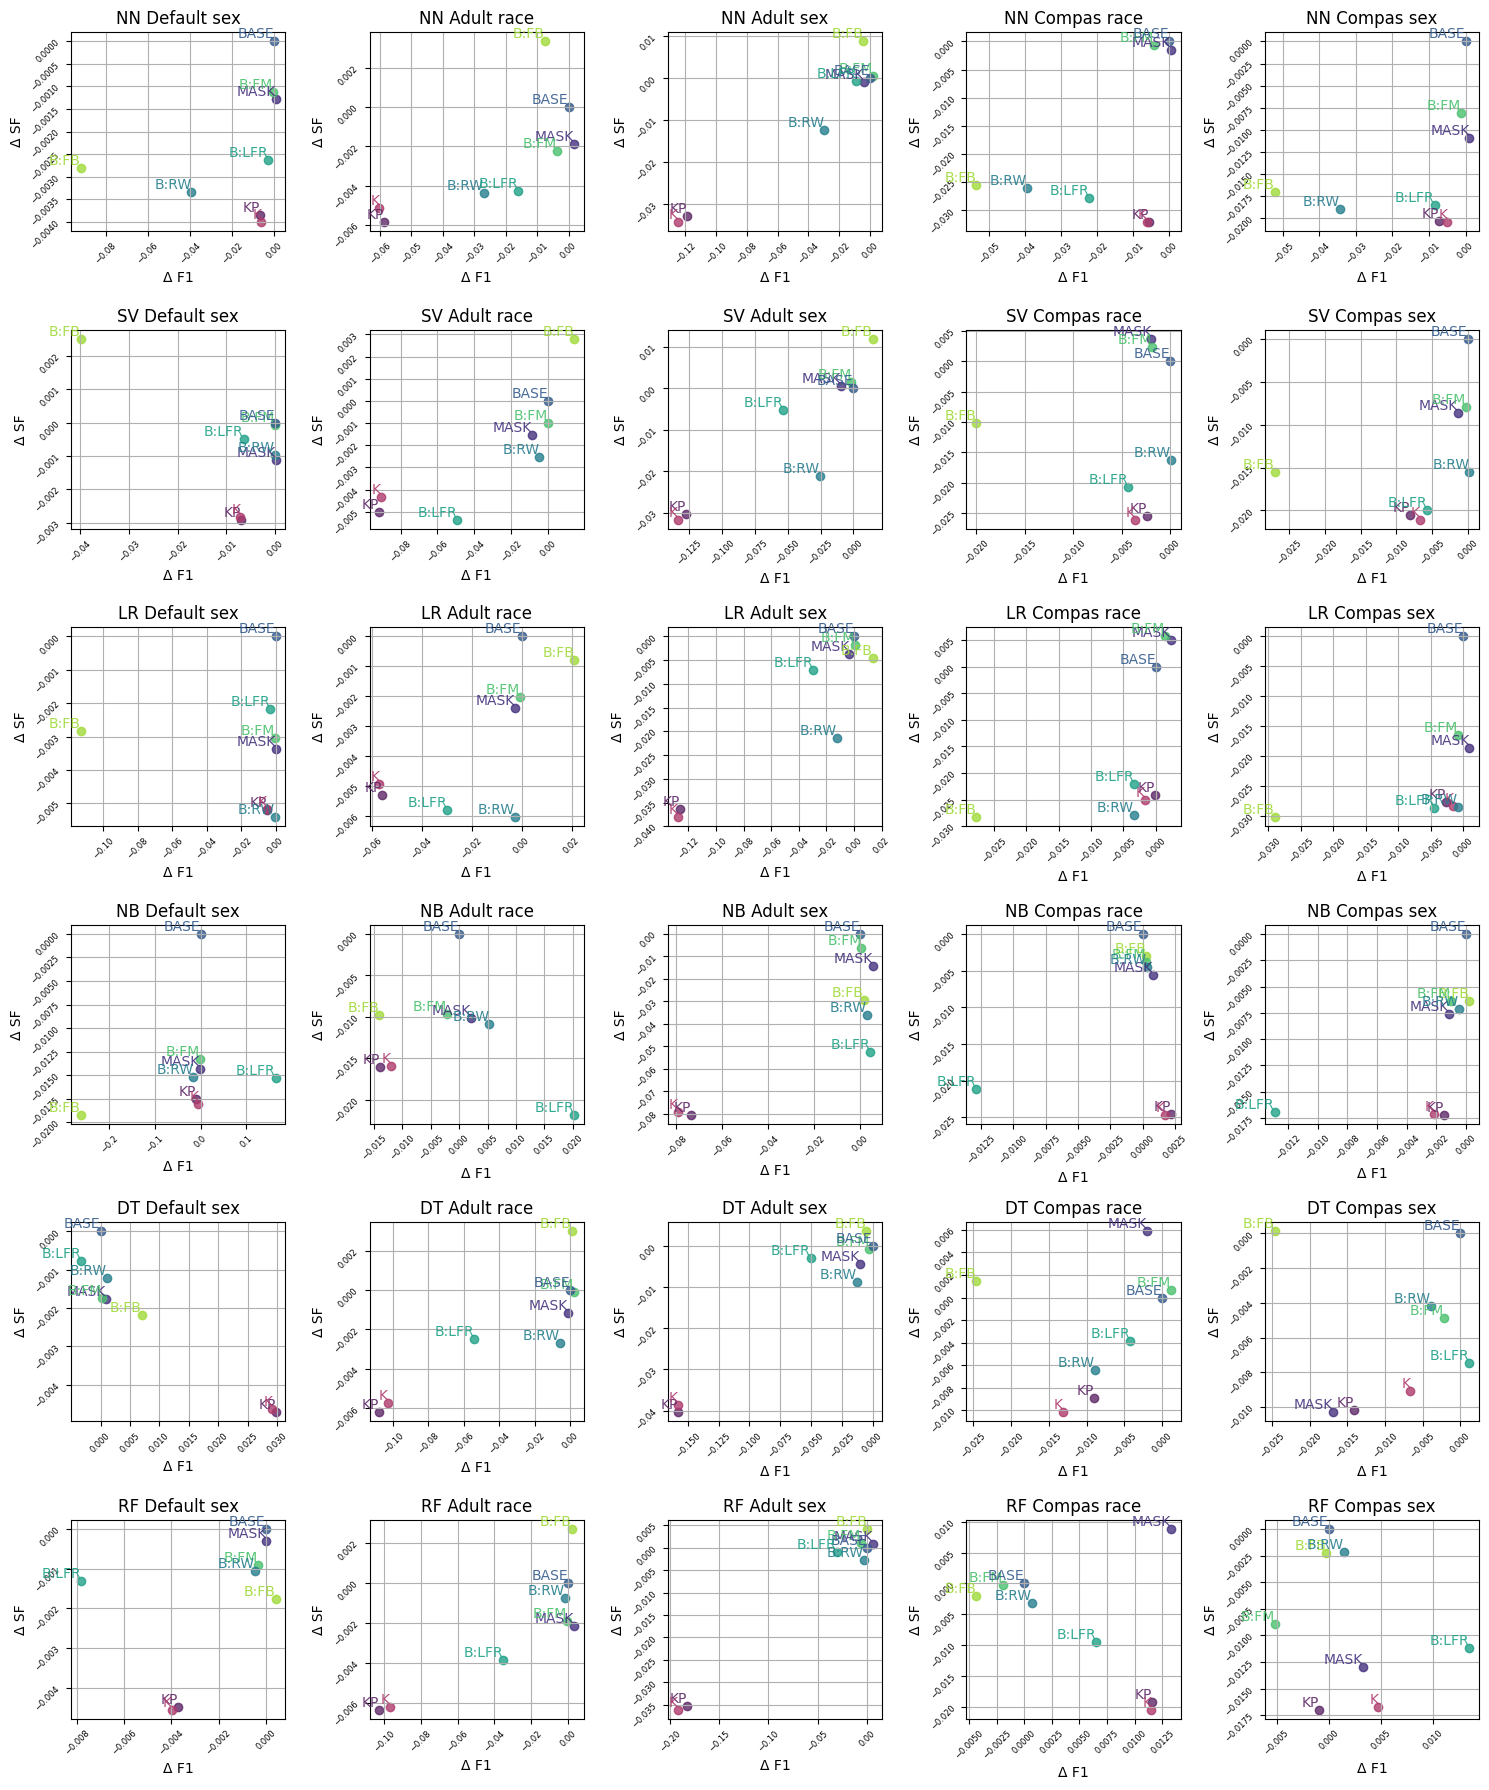

In [11]:

F, axes = plt.subplots(6, 5, figsize=(size*(5), size*6))
for j in range(6):
    model_short, model_name = models[j]
    fltr = lambda df, reader: f(df, reader, model_name)
    for i in range(5):
        plot_one_run(fltr, files[i], datasets[i], axes[j][i])
        axes[j][i].set_title(model_short+' '+titles[i])
        axes[j][i].set_ylabel("Δ SF") # comment out to make sure 
        axes[j][i].set_xlabel("Δ F1")
        
plt.rc('axes', axisbelow=True)
plt.tight_layout()
plt.savefig('imgs/RQ5_all_models_F1_SF.png')
plt.show()
# TODO: maybe standardise the sf and f1 scales

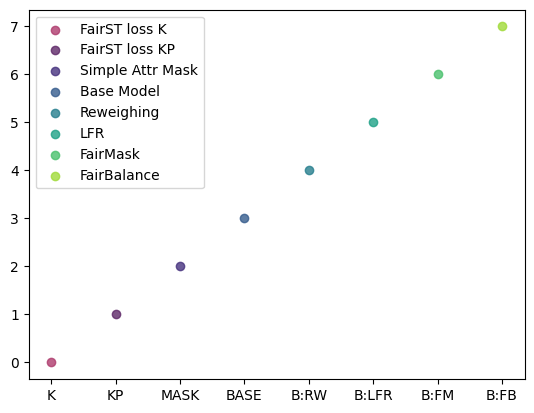

In [12]:
# LEGEND!
grapher = ResultsGrapher(None)
labels  = ["K","KP","MASK",'BASE',"B:RW","B:LFR","B:FM","B:FB"]
for i, l in enumerate(labels):
    plt.scatter(
            l,
            i,
            label=grapher._get_legend_text(l, l),
            color=grapher.get_color(l),
            alpha=0.8,
        )
plt.legend()
plt.show()

File 'results\RESULTS_with_no_vae_sex.csv' successfully loaded as DataFrame.
metrics to display: [SF] Statistical Parity Subgroup Fairness f1score  | all found  ['sex|[SF] Statistical Parity Subgroup Fairness for One Attribute', '[SF] Statistical Parity Subgroup Fairness'] ['f1score']
File 'results\RESULTS_with_no_vae_race.csv' successfully loaded as DataFrame.
metrics to display: [SF] Statistical Parity Subgroup Fairness f1score  | all found  ['race|[SF] Statistical Parity Subgroup Fairness for One Attribute', '[SF] Statistical Parity Subgroup Fairness'] ['f1score']
File 'results\RESULTS_with_no_vae_sex.csv' successfully loaded as DataFrame.
metrics to display: [SF] Statistical Parity Subgroup Fairness f1score  | all found  ['sex|[SF] Statistical Parity Subgroup Fairness for One Attribute', '[SF] Statistical Parity Subgroup Fairness'] ['f1score']
File 'results\RESULTS_with_no_vae_race.csv' successfully loaded as DataFrame.
metrics to display: [SF] Statistical Parity Subgroup Fairness 

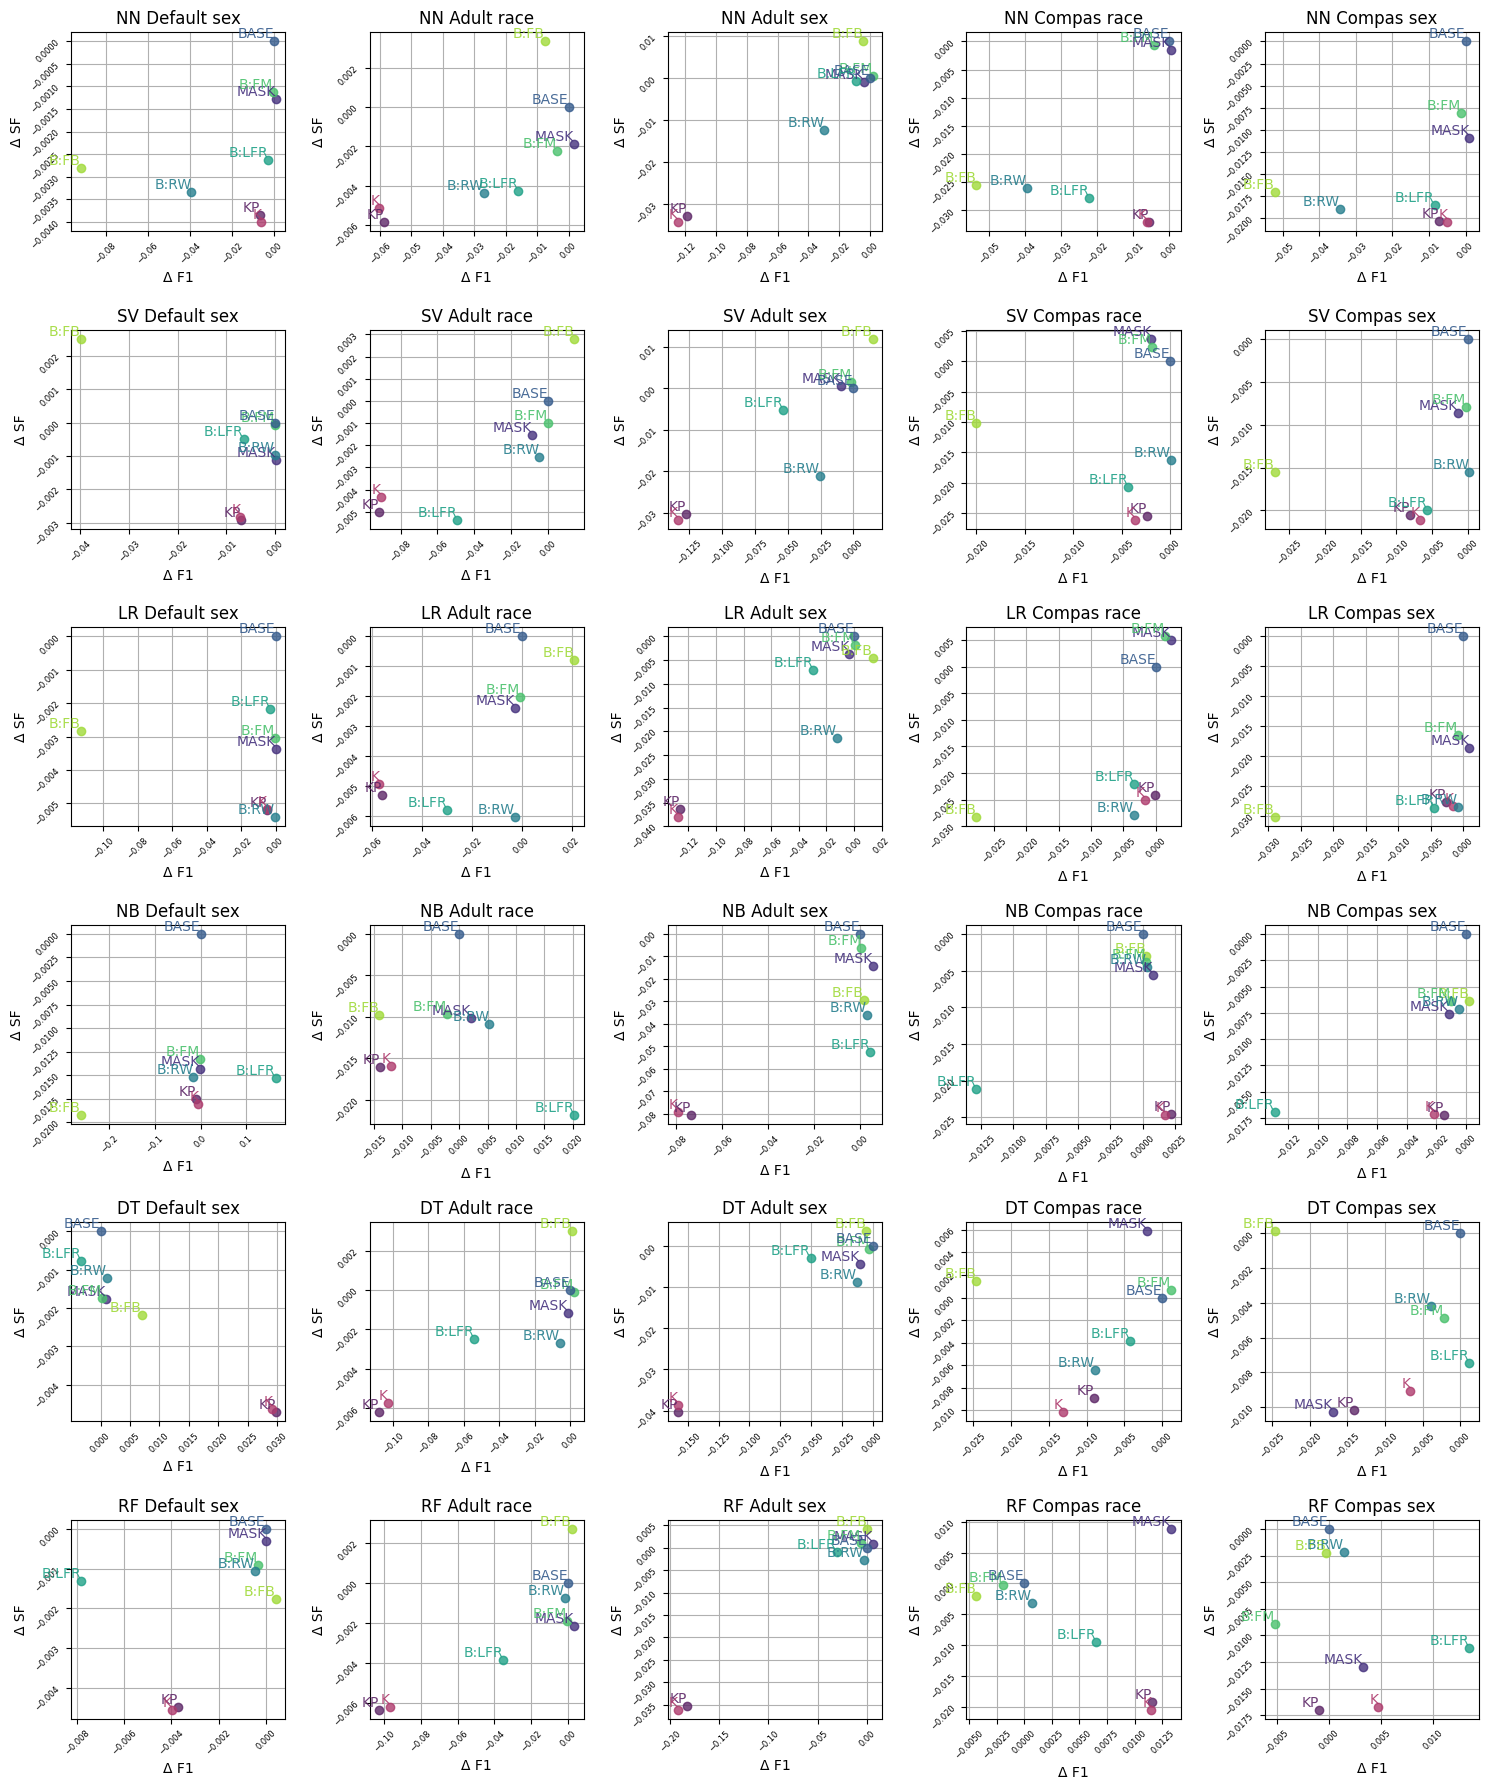

In [13]:

F, axes = plt.subplots(6, 5, figsize=(size*(5), size*6))
for j in range(6):
    model_short, model_name = models[j]
    fltr = lambda df, reader: f(df, reader, model_name)
    for i in range(5):
        plot_one_run(fltr, files[i], datasets[i], axes[j][i], y_metric='SF')
        axes[j][i].set_title(model_short+' '+titles[i])
        axes[j][i].set_ylabel("Δ SF") # comment out to make sure 
        axes[j][i].set_xlabel("Δ F1")
        
plt.rc('axes', axisbelow=True)
plt.tight_layout()
plt.savefig('imgs/RQ5_all_models_F1_DF.png')
plt.show()
# TODO: maybe standardise the sf and f1 scales